<a href="https://colab.research.google.com/github/ssundar6087/autoencoders/blob/main/vae_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
IMG_SIZE = 28
N_CHANNELS = 1

In [4]:
# Load the dataset
transform = transforms.Compose(
    [
    transforms.ToTensor(),
     ])

train_dataset = datasets.FashionMNIST(root=".", 
                                      download=True, 
                                      train=True,
                                      transform=transform,
                                      )

test_dataset = datasets.FashionMNIST(root=".", 
                                      download=True, 
                                      train=False,
                                      transform=transform,
                                      )

In [5]:
# Create dataloaders
batch_size=128
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

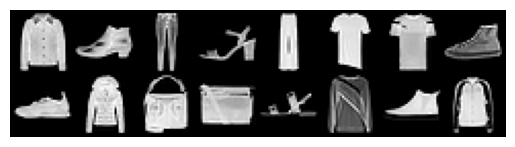

In [6]:
# Plot some images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
#print(dataiter)
images, labels = next(dataiter)

# show image
imshow(torchvision.utils.make_grid(images[:16]))

In [7]:
# Encoder
class Encoder(nn.Module):
  def __init__(self, 
               in_dim, 
               in_channels, 
               encoding_dim,
               device,
               ):
    super(Encoder, self).__init__()

    # Define the layers of the encoder
    self.encoding_dim = encoding_dim
    self.fc_dim = 512
    self.in_channels = in_channels
    self.in_dim = in_dim
    self.device = device
    self.flatten_dim = self.in_channels * self.in_dim**2
    self.fc1 = nn.Linear(self.flatten_dim, 
                         self.fc_dim,
                         )
    self.relu = nn.ReLU()
    
    self.mean = nn.Linear(self.fc_dim, self.encoding_dim)
    self.var = nn.Linear(self.fc_dim, self.encoding_dim)

    

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    mu =  self.mean(x)
    logvar = self.var(x) 

    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std)
    return mu + epsilon * std


In [8]:
vae_encoder_test = Encoder(in_dim=IMG_SIZE,
                           in_channels=N_CHANNELS,
                           encoding_dim = 128,
                           device=device,)


In [9]:
random_tns = torch.randn(size=(33,N_CHANNELS,IMG_SIZE,IMG_SIZE))
random_tns = random_tns.to(device)
vae_encoder_test = vae_encoder_test.to(device)

In [10]:
mu, logvar = vae_encoder_test(random_tns)
out = vae_encoder_test.reparameterize(mu, logvar)
out.shape

torch.Size([33, 128])

In [11]:
# Decoder
class Decoder(nn.Module):
  def __init__(self, 
               out_dim, 
               out_channels, 
               encoding_dim,
               device,
               ):
    super(Decoder, self).__init__()
    self.encoding_dim = encoding_dim
    self.fc_dim = 512
    self.out_channels = out_channels
    self.out_dim = out_dim
    self.device = device

    self.reshape_dim = self.out_channels * self.out_dim**2
    self.fc1 = nn.Linear(self.encoding_dim,  
                         self.fc_dim,
                         )
    self.fc2 = nn.Linear(self.fc_dim, self.reshape_dim)
    self.relu = nn.ReLU()

  def forward(self, z):
    z = self.relu(self.fc1(z))
    y = torch.sigmoid(self.fc2(z))
    return y.reshape((-1, 
                      self.out_channels,
                      self.out_dim,
                      self.out_dim,
                      )) 

In [12]:
vae_decoder_test = Decoder(out_dim=IMG_SIZE,
                           out_channels=N_CHANNELS,
                           encoding_dim=128,
                           device=device,
                           )

In [13]:
vae_decoder_test = vae_decoder_test.to(device)
final_out = vae_decoder_test(out)
final_out.shape

torch.Size([33, 1, 28, 28])

In [14]:
# Define model
class VAE(nn.Module):
  def __init__(self, 
               in_dim, 
               n_channels, 
               encoding_dim,
               device,
               ):
    super(VAE, self).__init__()

    # Parameters
    self.dim = in_dim
    self.channels = n_channels
    self.encoding_dim = encoding_dim
    self.device = device

    # Encoder
    self.encoder = Encoder(self.dim,
                           self.channels,
                           self.encoding_dim,
                           self.device,
                           )
    # Decoder
    self.decoder = Decoder(self.dim,
                           self.channels,
                           self.encoding_dim,
                           self.device,
                           )
    # Latent codes
    self.mu = 0
    self.logvar = 0
  
  def forward(self, x):
    # Pass through the encoder
    self.mu, self.logvar = self.encoder(x)
    z = self.encoder.reparameterize(self.mu, self.logvar)

    # Reconstruct using decoder
    y = self.decoder(z)
    return y

In [15]:
vae_test = VAE(in_dim=IMG_SIZE,
               n_channels=N_CHANNELS,
               encoding_dim=128,
               device=device,
               )
vae_test = vae_test.to(device)

In [16]:
output = vae_test(random_tns)
output.shape

torch.Size([33, 1, 28, 28])

In [17]:
IN_DIM = IMG_SIZE
ENCODING_DIM = 2 
vae = VAE(IN_DIM, N_CHANNELS, ENCODING_DIM, device)
vae = vae.to(device)

In [18]:
def vae_loss(input, reconstruction, mu, logvar):
  # Reconstruction loss
  reconstruction_loss = ((input - reconstruction)**2).mean()
  # KL Divergence loss
  kl_loss = -0.5 * torch.sum(1 + logvar - torch.exp(logvar) - mu**2, axis=-1)
  mean_kl_loss = torch.mean(kl_loss) / (N_CHANNELS * IMG_SIZE**2)
  return reconstruction_loss + mean_kl_loss

In [19]:
# Optimizer and Loss function
criterion = vae_loss # Loss Function
optimizer = torch.optim.Adam(vae.parameters(), lr=0.005) # Optimizer
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) 

In [20]:
def visualize_samples(model, test_loader, num_samples, skip=1):
  # Visualize reconstructions
  # obtain one batch of test images
  dataiter = iter(test_loader)
  for _ in range(skip):
    images, labels = next(dataiter)
  model.eval()
  # get reconstruction
  with torch.no_grad():
    output = model(images.to(device))

  images = images[:num_samples].permute(0, 2, 3, 1).numpy()
  output = output.detach().cpu().permute(0, 2, 3, 1).numpy()
  output = output[:num_samples]


  # plot images and their reconstructions
  fig, axes = plt.subplots(nrows=2, 
                          ncols=num_samples, 
                          sharex=True, 
                          sharey=True, figsize=(25,4))

  # input images on top row, reconstructions on bottom
  titles = ['original', 'reconstruction']
  for images, row, title in zip([images, output], axes, titles):
      for img, ax in zip(images, row):
          ax.imshow(img, cmap="gray")
          ax.get_xaxis().set_visible(False)
          ax.set_ylabel(title)
          ax.set_yticks([])
          ax.set_yticklabels([])
  plt.show()
  plt.pause(2)
  plt.close()

In [21]:
def train_step(model, train_loader, optimizer, criterion):
  model.train()
  epoch_loss = []
  total, correct = 0, 0

  for i, batch in tqdm(enumerate(train_loader), 
                       total=len(train_loader),
                       leave=False,
                       ):
    images, labels = batch
    images = images.to(device)

    optimizer.zero_grad() # Erase history - clean slate

    reconstruction = model(images) 
    loss = criterion(images, reconstruction, model.mu, model.logvar)
    epoch_loss.append(loss.item())

    loss.backward() # backward pass
    optimizer.step() # Update the weights using gradients
  
  return np.mean(epoch_loss)

In [22]:
def valid_step(model, val_loader, criterion):
  model.eval()
  epoch_loss = []
  total, correct = 0, 0

  with torch.no_grad():
    for i, batch in tqdm(enumerate(val_loader), 
                        total=len(val_loader),
                        leave=False,
                        ):
      images, labels = batch
      images = images.to(device)

      reconstruction = model(images) 
      loss = criterion(images, reconstruction, model.mu, model.logvar)
      epoch_loss.append(loss.item())
  
  return np.mean(epoch_loss)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[1] train loss: 0.04508629274457248  val loss: 0.039682727920103675


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[2] train loss: 0.03909056438311839  val loss: 0.03862214795773542


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[3] train loss: 0.03815460255119338  val loss: 0.037867332325328754


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[4] train loss: 0.03759000907098052  val loss: 0.03746013404636443


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[5] train loss: 0.03719729643418337  val loss: 0.03694238310939149


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[6] train loss: 0.036877752120878654  val loss: 0.036917497227086295


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[7] train loss: 0.03665527934903529  val loss: 0.03668133782435067


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[8] train loss: 0.036522291330640506  val loss: 0.03677333839520623


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[9] train loss: 0.036316765285631235  val loss: 0.03627681755755521


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

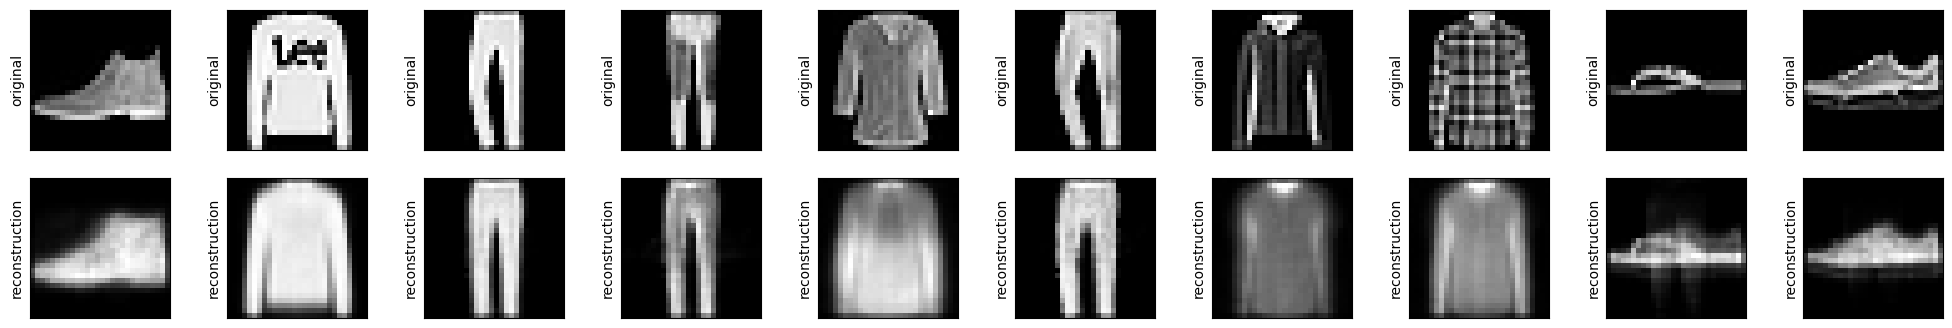

[10] train loss: 0.0362269563524962  val loss: 0.036297183719616904


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[11] train loss: 0.036037835612225885  val loss: 0.036432694879513755


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[12] train loss: 0.03593341399357517  val loss: 0.036149857495027256


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[13] train loss: 0.0357724462888007  val loss: 0.03592108873815476


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[14] train loss: 0.03568286636570242  val loss: 0.036078889205863204


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[15] train loss: 0.03559170774162324  val loss: 0.035837334026641486


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[16] train loss: 0.0354884808648751  val loss: 0.03585956415420846


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[17] train loss: 0.03541912576521256  val loss: 0.035640395093190516


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[18] train loss: 0.03532989987178144  val loss: 0.03560785567270049


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[19] train loss: 0.03527212435248564  val loss: 0.03557708055441138


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

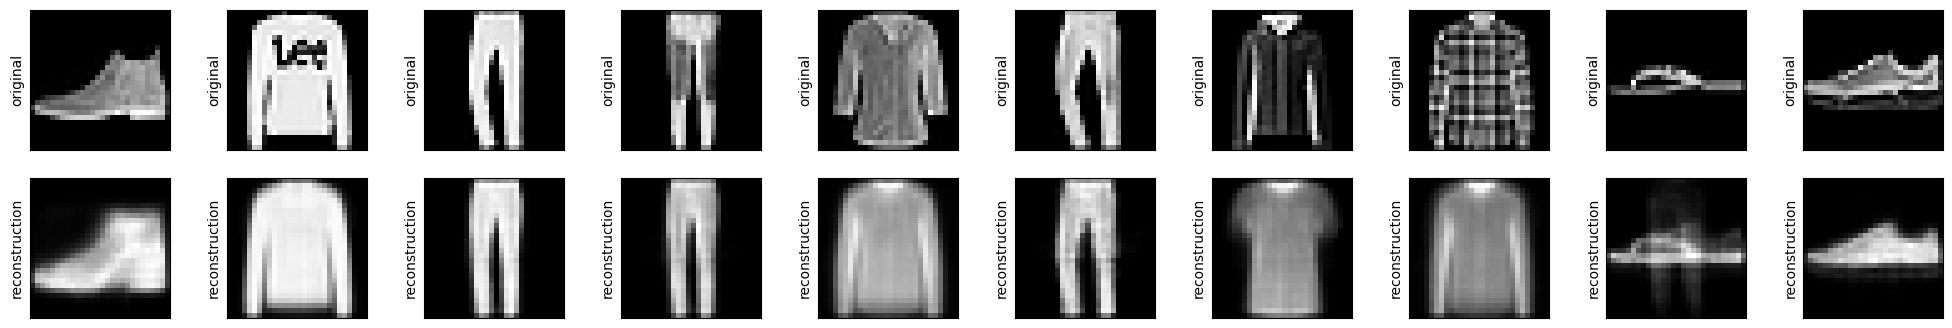

[20] train loss: 0.035193486016061  val loss: 0.03547156866215452


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[21] train loss: 0.03508489518992301  val loss: 0.03569222265217878


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[22] train loss: 0.03503321409860908  val loss: 0.035384873281928554


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[23] train loss: 0.0350374147168863  val loss: 0.035446952321106874


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[24] train loss: 0.03493055417688925  val loss: 0.03537014659635628


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[25] train loss: 0.034891709951417785  val loss: 0.0352584003364738


In [23]:
# training loop
EPOCHS = 25
losses = {"train_loss": [], "val_loss": []}
epochs = []
for epoch in tqdm(range(EPOCHS), total=EPOCHS):
  train_loss = train_step(vae, 
                          trainloader, 
                          optimizer, 
                          criterion,
                          )
  
  val_loss = valid_step(vae, 
                        testloader, 
                        criterion,
                        )
  
  if (epoch + 1) % 10 == 0:
    visualize_samples(vae, testloader, 10)
  scheduler.step()
  losses["train_loss"].append(train_loss)
  losses["val_loss"].append(val_loss)
  epochs.append(epoch)

  print(f'[{epoch + 1}] train loss: {train_loss}  val loss: {val_loss}')

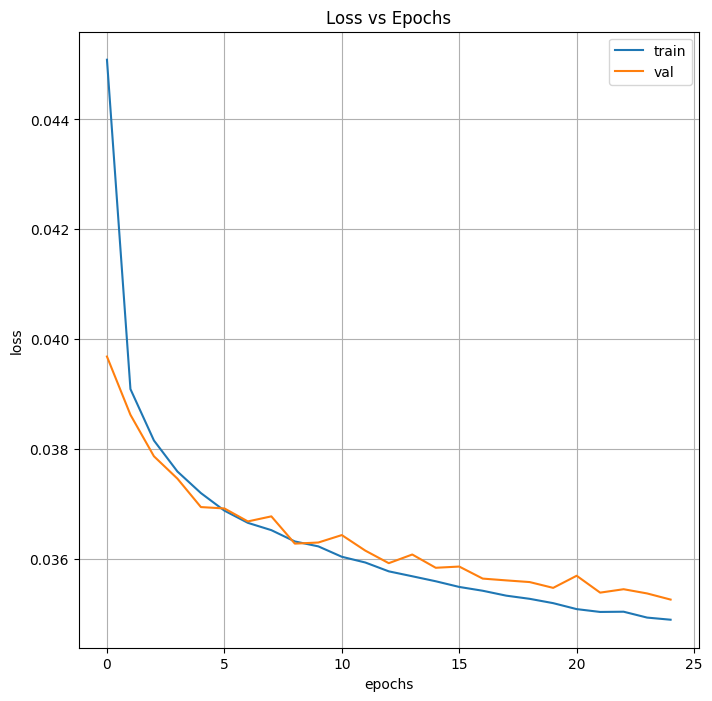

In [24]:
# Plot loss
plt.figure(figsize=(8,8))
plt.plot(epochs, losses["train_loss"], label="train")
plt.plot(epochs, losses["val_loss"], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.title("Loss vs Epochs");

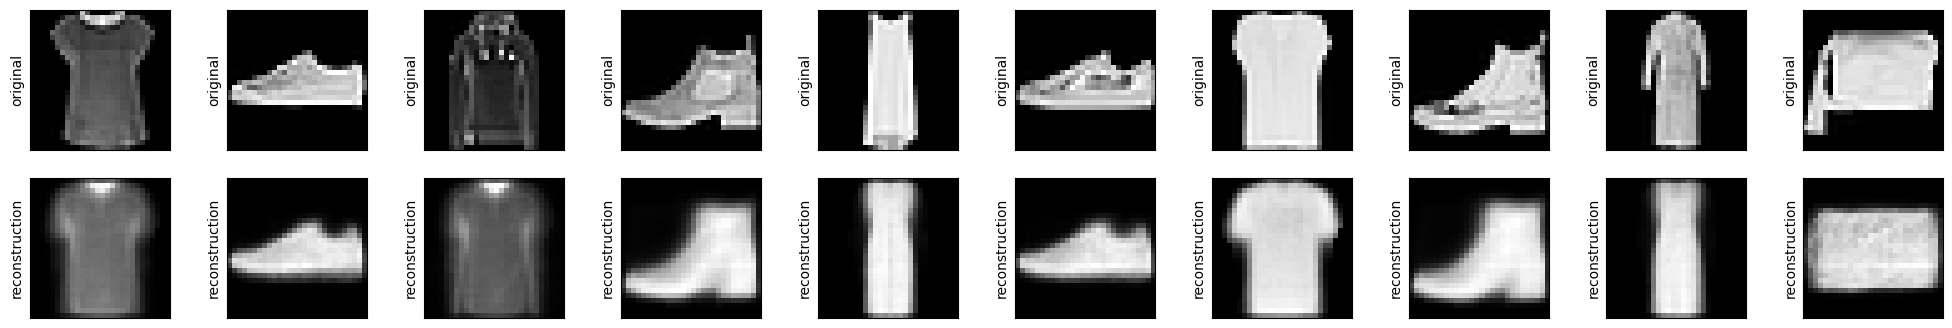

In [25]:
# Visualize reconstructions
# obtain one batch of test images
visualize_samples(vae, testloader, 10, skip=10)
        

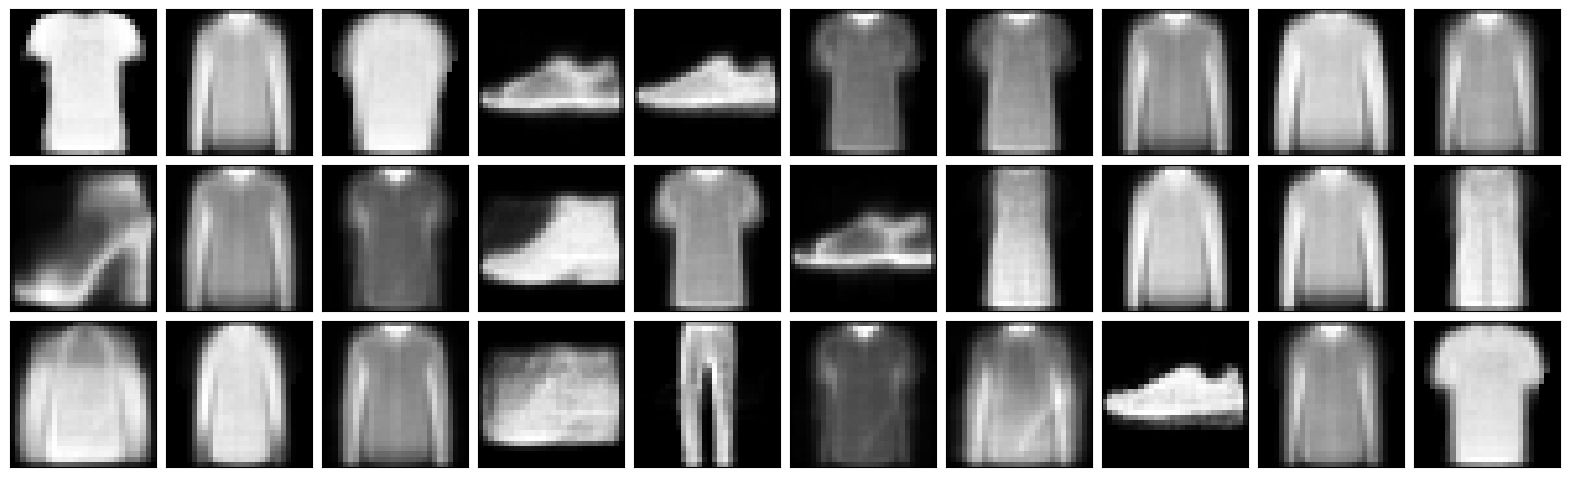

In [26]:
# Generate new samples
N_EXAMPLES = 30
z = torch.randn(N_EXAMPLES, ENCODING_DIM)
z = z.to(device)
with torch.no_grad():
  generated_samples = vae.decoder(z)

generated_samples = generated_samples.detach().cpu().permute(0, 2, 3, 1).numpy()

# plot generated samples
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(N_EXAMPLES // 10, 10),  
                 axes_pad=0.1,  # pad between axes
                 )
for ax, im in zip(grid, generated_samples):
    ax.imshow(im, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()